In [1]:
import mdtraj as md
from sklearn.decomposition import PCA
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import make_interp_spline

In [2]:
## Load the WT trajectory
traj_WT = md.load_xtc("../WT_MD/Simulation_files/WNT5A_AF_200ns_mdrun_whole_nopbc_nowat.xtc", top = "../WT_MD/Simulation_files/WNT5A_AF_200ns_mdrun_nowat.gro")

In [3]:
## Define PCA
pca1 = PCA(n_components=2)
traj_WT.superpose(traj_WT, 0)

<mdtraj.Trajectory with 2001 frames, 5183 atoms, 337 residues, and unitcells at 0x2a4313e90>

In [4]:
## Apply PCA
reduced_cartesian = pca1.fit_transform(
    traj_WT.xyz.reshape(traj_WT.n_frames, traj_WT.n_atoms * 3)
)
print(reduced_cartesian.shape)

(2001, 2)


(-15.0, 35.0)

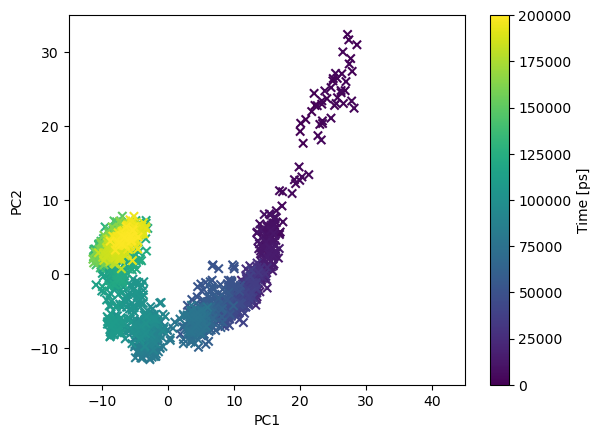

In [5]:
## Plot PCA
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:, 1], marker="x", c=traj_WT.time)
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar()
cbar.set_label("Time [ps]")

plt.xlim(-15,45)
plt.ylim(-15,35)

#plt.savefig("WT_PCA_v1.png", dpi = 300)

In [6]:
## Load mutated structure
traj_Mut = md.load_xtc("../V310M_MD/md_simulations/V310M_WNT5A_200ns_mdrun_nowater.xtc", top = "../V310M_MD/md_simulations/V310M_WNT5A_200ns_mdrun_nowater.gro")

In [7]:
## Define PCA
pca2 = PCA(n_components=2)
traj_Mut.superpose(traj_Mut, 0)

<mdtraj.Trajectory with 2001 frames, 5184 atoms, 337 residues, and unitcells at 0x2a4609350>

In [8]:
## Apply PCA
reduced_cartesian2 = pca2.fit_transform(
    traj_Mut.xyz.reshape(traj_Mut.n_frames, traj_Mut.n_atoms * 3)
)
print(reduced_cartesian2.shape)

(2001, 2)


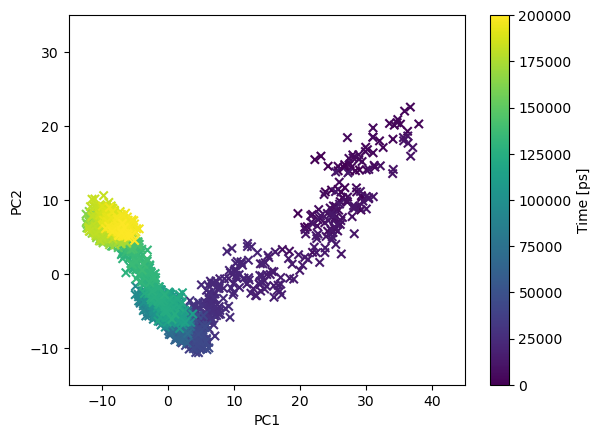

In [9]:
## Plot figure
plt.figure()
plt.scatter(reduced_cartesian2[:, 0], reduced_cartesian2[:, 1], marker="x", c=traj_Mut.time)
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.xlim(-15,45)
plt.ylim(-15,35)
cbar = plt.colorbar()
cbar.set_label("Time [ps]")

#plt.savefig("MUT_PCA_v1.png", dpi = 300)

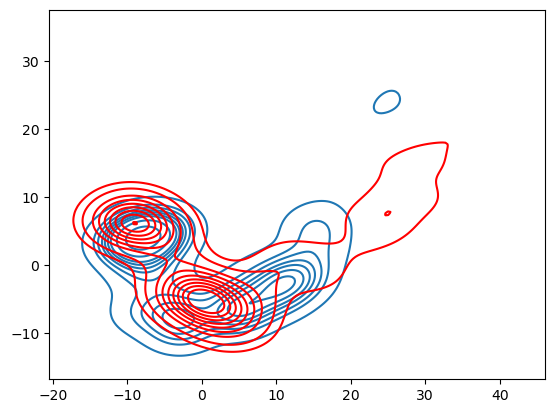

In [10]:
## KDE plot

g = sns.kdeplot(
    x=reduced_cartesian[:,0], y=reduced_cartesian[:,1], fill=False,
)

g2 = sns.kdeplot(
    x=reduced_cartesian2[:,0], y=reduced_cartesian2[:,1], fill=False, color = "red"
)

## RMSD calculations

In [12]:
crystal = md.load("../V310M_MD/starting_frame.gro")
traj_WT_only = md.load_xtc(
     "../V310M_MD/md_simulations/V310M_WNT5A_200ns_mdrun_nowater.xtc", top=crystal
)  # load the xtc. the crystal structure defines the topology


rmsds_to_crystal = md.rmsd(traj_WT_only, crystal)
heavy_atoms = [
    atom.index for atom in crystal.topology.atoms if atom.element.symbol != "H"
]
heavy_rmds_to_crystal_WT = md.rmsd(traj_WT_only, crystal, 0, atom_indices=heavy_atoms)

In [13]:
crystal = md.load("../WT_MD/starting_frame.gro")
traj_WT_only = md.load_xtc(
     "../WT_MD/Simulation_files/WNT5A_AF_200ns_mdrun_whole_nopbc_nowat.xtc", top=crystal
)  # load the xtc. the crystal structure defines the topology


rmsds_to_crystal = md.rmsd(traj_WT_only, crystal)
heavy_atoms = [
    atom.index for atom in crystal.topology.atoms if atom.element.symbol != "H"
]
heavy_rmds_to_crystal_MUT = md.rmsd(traj_WT_only, crystal, 0, atom_indices=heavy_atoms)

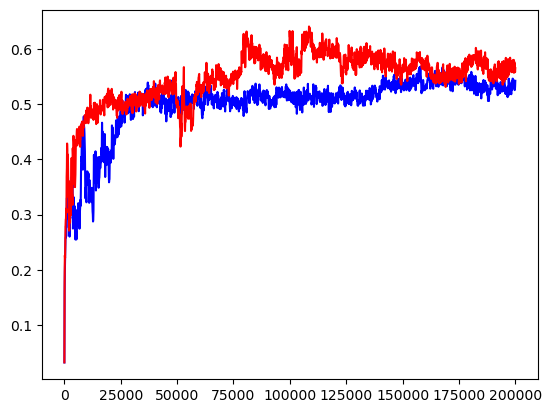

In [14]:
g = plt.plot(traj_WT_only.time, heavy_rmds_to_crystal_WT, "b")
g2 = plt.plot(traj_WT_only.time, heavy_rmds_to_crystal_MUT, "r")

In [139]:
import scipy.stats

In [140]:
## Mann Whitney for RMSDs
scipy.stats.mannwhitneyu(heavy_rmds_to_crystal_MUT[250:], heavy_rmds_to_crystal_WT[250:])

MannwhitneyuResult(statistic=2622712.0, pvalue=1.73192525901136e-290)

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_70823/4260675504.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size = 16)


Text(0.5409999999999999, 24, 'p = 1.7e-290')

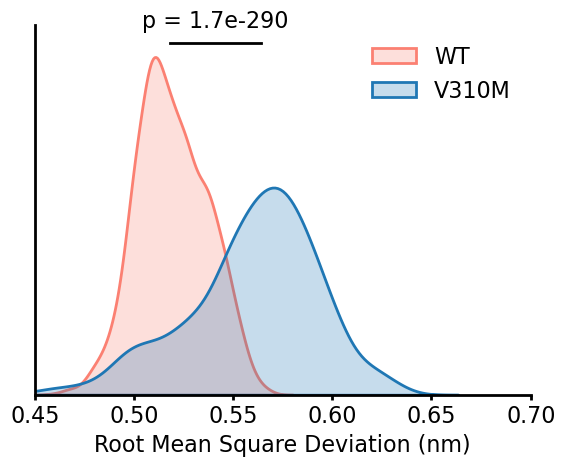

In [16]:
## Plot RMSD distributions
g = sns.kdeplot(heavy_rmds_to_crystal_WT[250:], fill=True, label= "WT", color = sns.color_palette("Set3")[3], lw =2)
g = sns.kdeplot(heavy_rmds_to_crystal_MUT[250:], fill = True, label = "V310M", lw = 2)
plt.legend(frameon = False, fontsize = 16)

g.spines['left'].set_linewidth(2)
g.spines['bottom'].set_linewidth(2)


g.set_xlabel("Root Mean Square Deviation (nm)", size = 16)
g.set_ylabel("")

g.set_xlim(0.45, 0.7)
g.set_xticklabels(g.get_xticklabels(), size = 16)
g.xaxis.set_tick_params(width=2)


g.set_yticks([])
sns.despine()

plt.plot((0.518, 0.564), (23, 23), lw = 2, c = "k")

plt.annotate("p = 1.7e-290", ((0.518 + ((0.564-0.518)/2)), 24), ha = "center", size = 16)

#plt.savefig("RMSD_md_simulations_v1.pdf", bbox_inches = "tight")

In [31]:
def argmedian(x):
  return np.argpartition(x, len(x) // 2)[len(x) // 2]

In [32]:
argmedian(heavy_rmds_to_crystal_MUT)

1682

In [33]:
argmedian(heavy_rmds_to_crystal_WT)

971